# Initialisation

Load caffe model (AlexNet?)

In [1]:
require 'loadcaffe'
require 'image'

-- Converts an image from RGB to BGR format and subtracts mean
function preprocess(im, img_mean)
  -- rescale the image
  local im3 = image.scale(im,224,224,'bilinear')*255
  -- RGB2BGR
  local im4 = im3:clone()
  im4[{1,{},{}}] = im3[{3,{},{}}]
  im4[{3,{},{}}] = im3[{1,{},{}}]

  -- subtract imagenet mean
  return im4 - image.scale(img_mean, 224, 224, 'bilinear')
end

-- Setting up networks 

prototxt_name = '/usr/local/data/CaffeZoo/caffenet-yos/deploy.prototxt'
binary_name = '/usr/local/data/CaffeZoo/caffenet-yos/caffenet-yos-weights'

print '==> Loading network'

net = loadcaffe.load(prototxt_name, binary_name, 'cudnn')

-- as we want to classify, let's disable dropouts by enabling evaluation mode
net:evaluate()

print '==> Loading image and imagenet mean'
image_name = 'Goldfish3.jpg'
img_mean_name = 'ilsvrc_2012_mean.t7'

im = image.load(image_name)
img_mean = torch.load(img_mean_name).img_mean:transpose(3,1)

-- Have to resize and convert from RGB to BGR and subtract mean
print '==> Preprocessing'
I = preprocess(im, img_mean)

==> Loading network	


Successfully loaded /usr/local/data/CaffeZoo/caffenet-yos/caffenet-yos-weights


MODULE data UNDEFINED


error loading module 'libcunn' from file '/home/yusheng/workspace/torch/install/lib/lua/5.1/libcunn.so':
	/home/yusheng/workspace/torch/install/lib/lua/5.1/libcunn.so: undefined symbol: _Z24THC_canUse32BitIndexMathP8THCStateP12THCudaTensor
stack traceback:
	[C]: at 0x7f670242d020
	[C]: in function 'require'
	...heng/workspace/torch/install/share/lua/5.1/cunn/init.lua:3: in main chunk
	[C]: in function 'require'
	/usr/local/data/CaffeZoo/caffenet-yos/deploy.prototxt.lua:2: in main chunk
	[C]: in function 'dofile'
	...pace/torch/install/share/lua/5.1/loadcaffe/loadcaffe.lua:20: in function 'load'
	[string "require 'loadcaffe'..."]:24: in main chunk
	[C]: in function 'xpcall'
	...ng/workspace/torch/install/share/lua/5.1/itorch/main.lua:177: in function <...ng/workspace/torch/install/share/lua/5.1/itorch/main.lua:143>
	...ng/workspace/torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	...workspace/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	...workspace/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	...workspace/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	...ng/workspace/torch/install/share/lua/5.1/itorch/main.lua:344: in main chunk
	[C]: in function 'require'
	[string "arg={'/home/yusheng/.ipython/profile_default/..."]:1: in main chunk: 

# Deconvolve feature maps (without upsampling)

==> Time elapsed: 0.07296085357666 seconds	
==> Deconv1 Feature Maps	

 96
 54
 54
[torch.LongStorage of size 3]



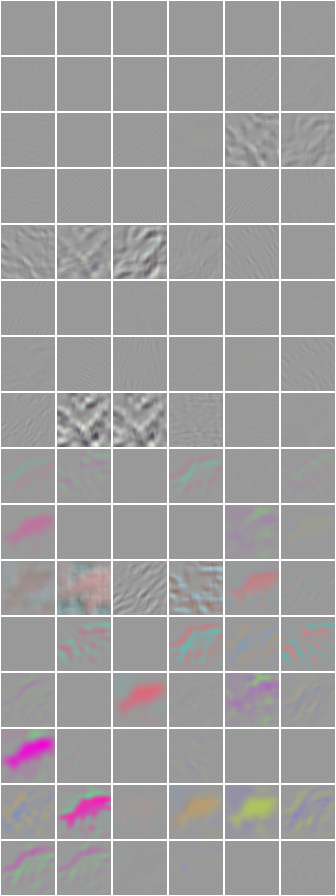

In [4]:
conv1 = net:get(1)
conv1_fm = conv1:forward(I:cuda())

timer = torch.Timer()

deconv1_fm = torch.Tensor(96, 3, conv1_fm:size(2), conv1_fm:size(3)):cuda()
deconv1 = cudnn.SpatialConvolution(1, 1, 11, 11, 1, 1, 5, 5):cuda()


for i=1,96 do
    for j=1,3 do
        fm = conv1_fm[i]
        
        deconv1.weight = conv1.weight[{ {i}, {j}, {}, {} }]:transpose(3, 4):contiguous()
        deconv_result = deconv1:forward(fm:view(1, conv1_fm:size(2), conv1_fm:size(3)))
        -- BGR to RGB    
        deconv1_fm[{ {i}, {3-(j-1)}, {}, {} }] = deconv_result
    end
end

cutorch.synchronize()
print('==> Time elapsed: ' .. timer:time().real .. ' seconds')

print '==> Deconv1 Feature Maps'
print(conv1_fm:size())
itorch.image(deconv1_fm:float())

# Deconvolve feature maps (with upsampling)

In [45]:
conv1 = net:get(1)
conv1_fm = conv1:forward(I:cuda())

-- Upsample feature map
ups = nn.SpatialUpSamplingNearest(torch.round(I:size(2)/conv1_fm:size(2)) + 1):cuda()

conv1_ups_fm = ups:forward(conv1_fm)

--print(conv1_ups_fm:size())

row_lb = (conv1_ups_fm:size(2) - I:size(2))/2
row_ub = conv1_ups_fm:size(2) - row_lb - 1

col_lb = (conv1_ups_fm:size(3) - I:size(3))/2
col_ub = conv1_ups_fm:size(3) - col_lb - 1

conv1_ups_fm = conv1_ups_fm[{ {}, {row_lb, row_ub}, {col_lb, col_ub} }]:contiguous()

--print(conv1_ups_fm:size())

-- Deconv
timer = torch.Timer()

deconv1_fm = torch.Tensor(96, 3, 224, 224):cuda()
deconv1 = cudnn.SpatialConvolution(1, 1, 11, 11, 1, 1, 5, 5):cuda()

for i=1,96 do
    for j=1,3 do
        fm = conv1_ups_fm[i]

        deconv1.weight = conv1.weight[{ {i}, {j}, {}, {} }]:transpose(3, 4):contiguous():cuda()
        deconv_result = deconv1:forward(fm:view(1, 224, 224))

        -- BGR to RGB    
        deconv1_fm[{ {i}, {3-(j-1)}, {}, {} }] = deconv_result
    end
end

cutorch.synchronize()
print('==> Time elapsed: ' .. timer:time().real .. ' seconds')

print '==> Deconv1 Feature Maps'
--itorch.image(deconv1_fm)



==> Time elapsed: 0.16782307624817 seconds	
==> Deconv1 Feature Maps	


#Deconvolve feature maps (with scattering)

In [57]:
conv1 = net:get(1)
cutorch.setDevice(1)
conv1_fm = conv1:forward(I:cuda())

timer = torch.Timer()
--Scatter feature map

conv1_scat_fm = torch.zeros(96, I:size(2), I:size(3)):cuda()
stride_size = 4
padding_size = (I:size(2) - (conv1_fm:size(2) * stride_size))/2

--Optimize
-- idx_tensor = torch.LongTensor( conv1_fm:size(2), conv1_fm:size(3)):zero()

-- local scat_x=padding_size+1
-- for j=1,conv1_fm:size(2) do
--     local scat_y=padding_size+1
--     for k=1,conv1_fm:size(3) do
--         idx_tensor[j][k] = 
--         scat_y = scat_y + stride_size
--     end

--     scat_x = scat_x + stride_size
-- end



-- for i=1,96 do
--     conv1_scat_fm[i]:scatter(1, idx_tensor, conv1_fm[i])
--end

--cutorch.reserveStreams(96)
for i=1,96 do
    local scat_x=padding_size+1
    for j=1,conv1_fm:size(2) do
        local scat_y=padding_size+1
        for k=1,conv1_fm:size(3) do
            conv1_scat_fm[i][scat_x][scat_y]=conv1_fm[i][j][k]
            scat_y = scat_y + stride_size
        end
        
        scat_x = scat_x + stride_size
    end
end

deconv1_fm = torch.Tensor(96, 3, 224, 224):cuda()
deconv1 = cudnn.SpatialConvolution(1, 1, 11, 11, 1, 1, 5, 5):cuda()

--cutorch.reserveStreams(96)
for i=1,96 do
    for j=1,3 do
        fm = conv1_scat_fm[i]
        
        deconv1.weight = conv1.weight[{ {i}, {j}, {}, {} }]:transpose(3, 4):contiguous():cuda()
        deconv_result = deconv1:forward(fm:view(1, 224, 224))

        -- BGR to RGB    
        deconv1_fm[{ {i}, {3-(j-1)}, {}, {} }] = deconv_result
    end
end

cutorch.synchronize()
print('==> Time elapsed: ' .. timer:time().real .. ' seconds')

print '==> Deconv1 Feature Maps'
print(conv1_fm:size())
--itorch.image(deconv1_fm:float())

==> Time elapsed: 3.9105980396271 seconds	
==> Deconv1 Feature Maps	

 96
 54
 54
[torch.LongStorage of size 3]



# Deconvole Unpooling Feature Maps

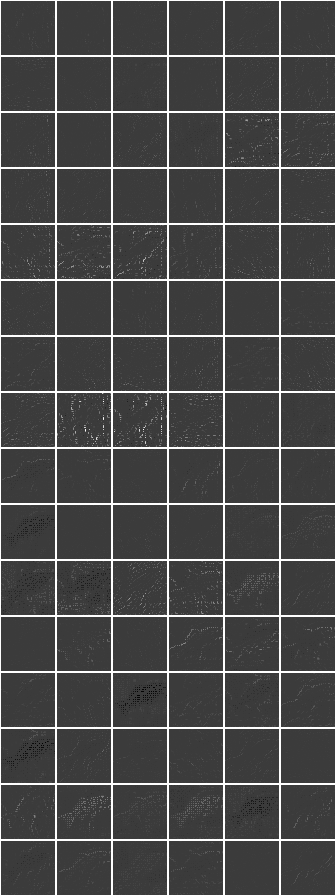

==> Time elapsed: 5.3017489910126 seconds	
==> Deconv1 Feature Maps	


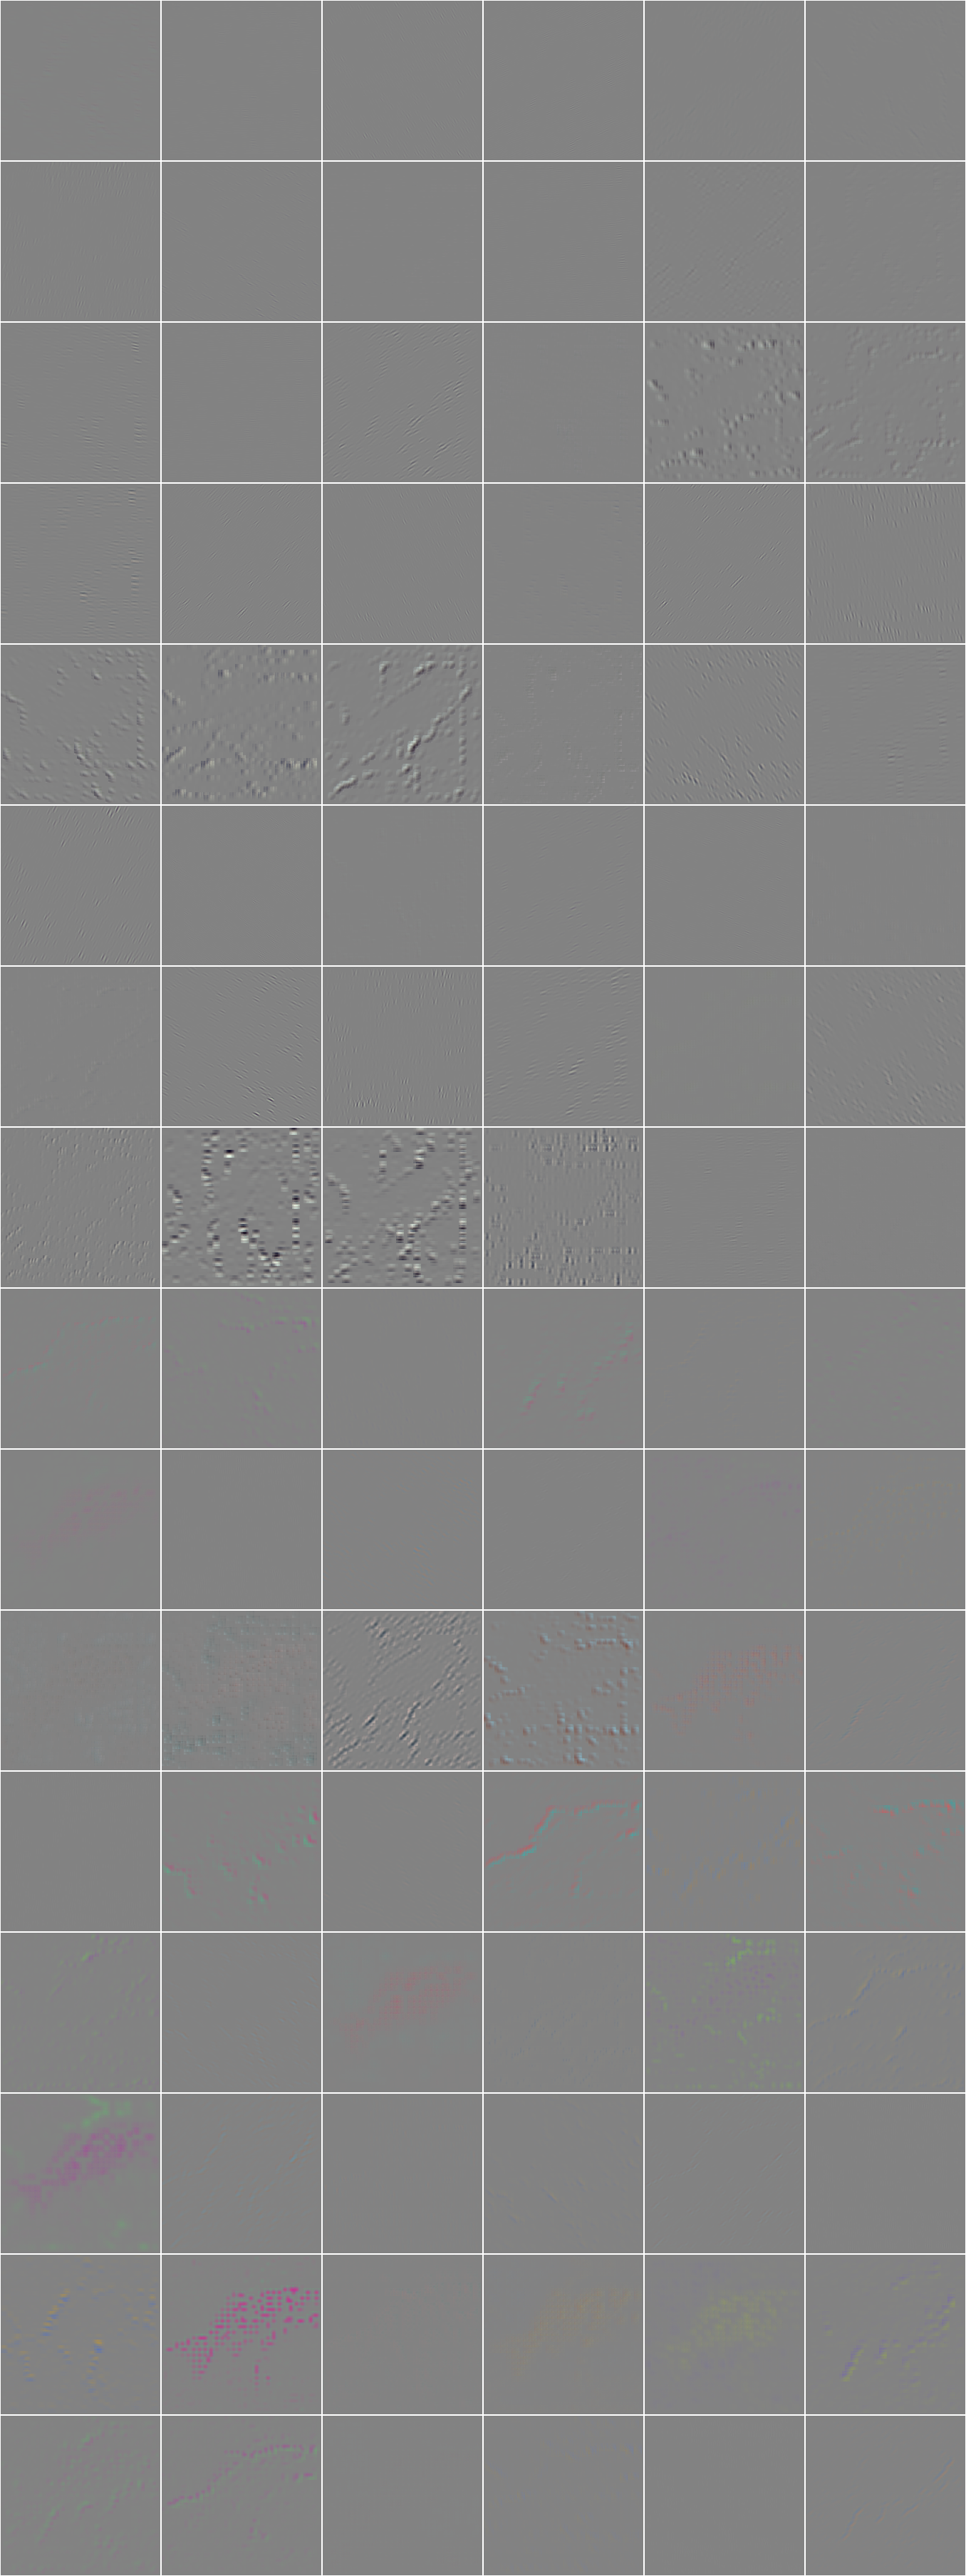

In [18]:
conv1 = net:get(1)
pool1 = nn.Sequential():cuda()
pool1:add(net:get(1))
--pool1:add(net:get(2))

conv1_fm = pool1:forward(I:cuda())

timer = torch.Timer()

--Unpooling

local stride_size = 2
local kernel_size = 3
unpool1_fm = torch.CudaTensor(96, conv1_fm:size(2), conv1_fm:size(3)):zero():cuda()

-- test = conv1_fm[{{1},{1,3},{1,3}}]
-- print(test)
-- max_col,idx_col = torch.max(test[1],2)
-- print(max_col)
-- print(idx_row)
-- max_val,idx_row = torch.max(max_col,1)
-- print(max_val)
-- print(idx_row)
-- print(idx_col[idx_row[1][1]])
-- print(test[1][idx_row[1][1]][idx_col[idx_row[1][1]][1]])

conv1_fm_p = nn.SpatialZeroPadding(0, stride_size-1, 0, stride_size-1 ):forward(conv1_fm:cuda()) --right and bottom padding 2

for i=1,96 do
    local x=1
    while x<=conv1_fm:size(2) do
        local y=1
        while y<=conv1_fm:size(3) do
            --if x+kernel_size-1<=54 and y+kernel_size-1<=54 then
                local x_ub = x+kernel_size-1
                local y_ub = y+kernel_size-1
                if x_ub > conv1_fm:size(2) then
                    x_ub = conv1_fm:size(2)
                end

                if y_ub > conv1_fm:size(3) then
                    y_ub = conv1_fm:size(3)
                end          

                local max_kernel = conv1_fm_p[{{i},{x,x_ub},{y,y_ub}}] 
                max_col,idx_col=torch.max(max_kernel[1],2)
                max_val,idx_row=torch.max(max_col,1)
                --if x-1+idx_row[1][1] <=54 and y-1+idx_col[idx_row[1][1]][1] <=54 then
                    unpool1_fm[i][x-1+idx_row[1][1]][y-1+idx_col[idx_row[1][1]][1]]=max_val
                --end
            --end
                
            y=y+stride_size
        end
        
        x=x+stride_size
    end
end


-- --Scatter feature map

unpool1_scat_fm = torch.zeros(96, I:size(2), I:size(3)):cuda()
--unpool1_scat_fm = nn.SpatialZeroPadding(0, 0, 0, 0):forward(unpool1_scat_fm:cuda()) 
stride_size = 4
padding_size = (I:size(2) - (conv1_fm:size(2) * stride_size))/2

for i=1,96 do
    local scat_x=padding_size+1
    for j=1,conv1_fm:size(2) do
        local scat_y=padding_size+1
        for k=1,conv1_fm:size(3) do
            unpool1_scat_fm[i][scat_x][scat_y]=unpool1_fm[i][j][k]
            scat_y = scat_y + stride_size
        end
        
        scat_x = scat_x + stride_size
    end
end
--cutorch.synchronize()

itorch.image(unpool1_fm:float())
deconv1_fm = torch.CudaTensor(96, 3, 224, 224):cuda()
deconv1 = cudnn.SpatialConvolution(1, 1, 11, 11, 1, 1, 5, 5):cuda()

for i=1,96 do
    for j=1,3 do
        fm = unpool1_scat_fm[i]
        
        deconv1.weight = conv1.weight[{ {i}, {j}, {}, {} }]:transpose(3, 4):contiguous()
        deconv_result = deconv1:forward(fm:view(1, 224, 224))

        -- BGR to RGB    
        deconv1_fm[{ {i}, {3-(j-1)}, {}, {} }] = deconv_result
    end
end

-- cutorch.synchronize()
print('==> Time elapsed: ' .. timer:time().real .. ' seconds')

print '==> Deconv1 Feature Maps'
itorch.image(deconv1_fm:float())